# **Assignment 8** 

1. Write a custom ResNet architecture for CIFAR10 that has the following architecture:
  - PrepLayer - Conv 3x3 s1, p1) >> BN >> RELU `[out channels = 64]`
  - Layer1
    - X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU `[out channels = 128]`
    - R1 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) `[out channels = 128]` 
    - Add(X, R1)
  - Layer 2
    - Conv 3x3 `[out channels = 256]`
    - MaxPooling2D
    - BN
    - ReLU
  - Layer 3
    - X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU `[out channels = 512]`
    - R2 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) `[out channels = 512]`
    - Add(X, R2)
  - Max Pooling with Kernel Size 4
  - FC Layer 
  - SoftMax

2. Uses One Cycle Policy such that:
  - Total Epochs = 24
  - Max at Epoch = 5
  - LRMIN = FIND
  - LRMAX = FIND
  - No Annihilation
3. Uses these transforms
  - RandomCrop(32, 32) (after padding of 4)
  - FlipLR
  - Followed by CutOut(8, 8)
4. Batch size = 512
5. Target Accuracy: 90% (93.8% quadruple scores). 
6. No score if your code is not modular. Your collab must be importing your GitHub package, and then just running the model. I should be able to find the custom_resnet.py model in your GitHub repo that you'd be training. 
7. Once done, proceed to answer the Assignment-Solution page. 

In [1]:
!rm -rf ./*
!git clone https://github.com/abhyuditjain/pytorch-models
!mv pytorch-models/* ./
!rm -rf pytorch-models
!pip install -r requirements.txt

Cloning into 'pytorch-models'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 131 (delta 82), reused 89 (delta 40), pack-reused 0
Receiving objects: 100% (131/131), 40.69 KiB | 3.70 MiB/s, done.
Resolving deltas: 100% (82/82), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38261 sha256=a11fa50df08ea27489e963454240d4dbce325d99b831b3e9550b595d3145beb9
  Stored in directory: /root/.cache/pip/wheels/53/02/43/1f75726b5c28459596067ad91e36951463c01273eef661f09f
Successfully built grad-cam


In [2]:
import copy
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
import torch.nn as nn
from utils.dataloader import Cifar10DataLoader
from utils.transforms import CustomResnetTransforms
from models.custom_resnet import CustomResNet
from utils.trainer import Trainer
from utils.tester import Tester
from utils.summary import print_summary
from utils.utils import show_misclassified_images, show_training_images, denormalize, show_grad_cam, show_losses_and_accuracies, get_module_by_name, get_device, show_lr_history
from main import train_model, get_lr, run # remove this

In [3]:
is_cuda_available, device = get_device()
print_summary(CustomResNet(), device, input_size=(3, 32, 32))

Layer (type (var_name))                  Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds                 Trainable
CustomResNet (CustomResNet)              --                        [20, 3, 32, 32]           [20, 10]                  --                        --                        True
├─Sequential (prep_layer)                --                        [20, 3, 32, 32]           [20, 64, 32, 32]          --                        --                        True
│    └─Conv2d (0)                        [3, 3]                    [20, 3, 32, 32]           [20, 64, 32, 32]          1,728                     35,389,440                True
│    └─BatchNorm2d (1)                   --                        [20, 64, 32, 32]          [20, 64, 32, 32]          128                       2,560                     True
│    └─ReLU (2)                          --                        [20, 64, 32, 32]          [20, 64, 32, 32]      

In [4]:
cifar10 = Cifar10DataLoader(CustomResnetTransforms, 512, is_cuda_available)
train_loader = cifar10.get_loader(train=True)
test_loader = cifar10.get_loader(train=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


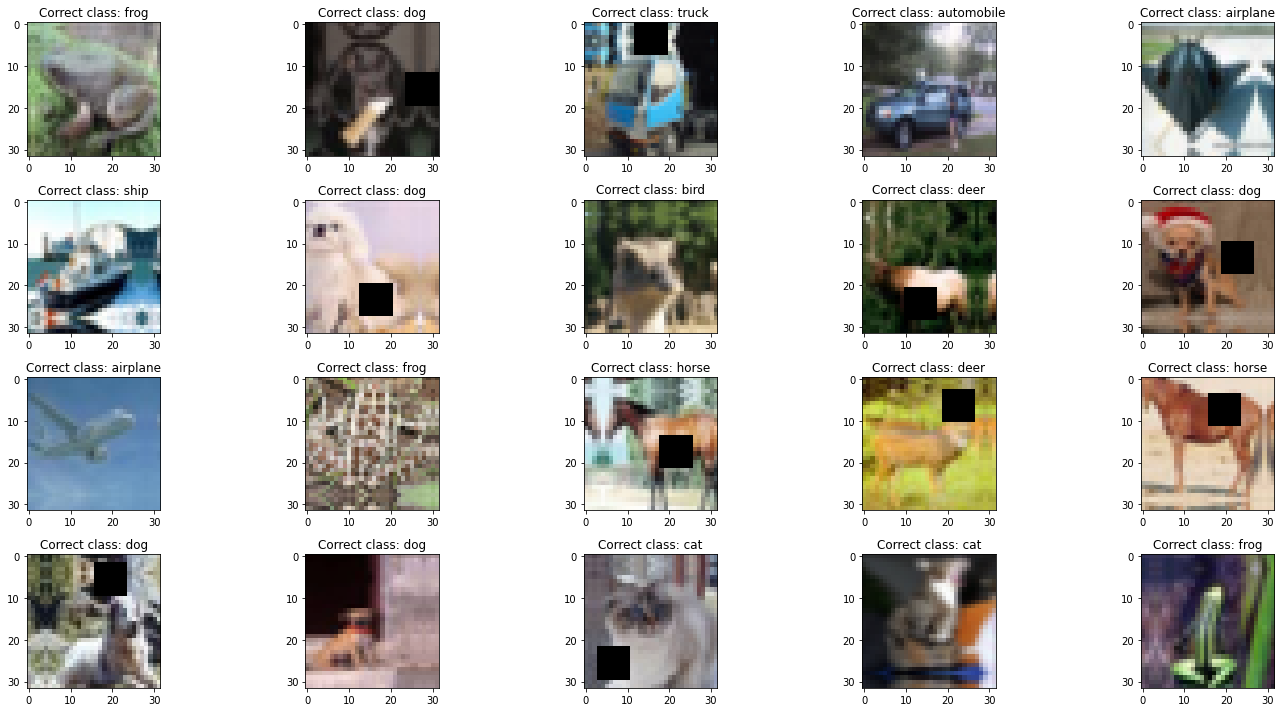

In [5]:
show_training_images(train_loader, 20, cifar10.classes)

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.83E-01


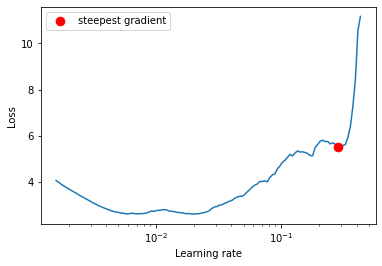

Min Loss = 2.5940928201241054, Max LR = 0.01933891750455231


In [70]:
model = CustomResNet()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

min_loss, max_lr = get_lr(model, train_loader, optimizer, criterion, device, end_lr=10, num_iter=200, step_mode='exp')

In [71]:
EPOCHS = 24

scheduler = OneCycleLR(
        optimizer,
        max_lr=max_lr,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )

trainer = Trainer(model, train_loader, optimizer, criterion, device)
tester = Tester(model, test_loader, criterion, device)

model, history = train_model(trainer, tester, NUM_EPOCHS=EPOCHS, scheduler=scheduler, save_best=False)

EPOCH = 1 | LR = 0.004030325322881239 | Loss = 1.37 | Batch = 97 | Accuracy = 35.77: 100%|██████████| 98/98 [00:23<00:00,  4.20it/s]


Test set: Average loss: 0.0029, Accuracy: 4886/10000 (48.86%)



EPOCH = 2 | LR = 0.007867261470716955 | Loss = 1.18 | Batch = 97 | Accuracy = 53.44: 100%|██████████| 98/98 [00:24<00:00,  4.05it/s]


Test set: Average loss: 0.0026, Accuracy: 5673/10000 (56.73%)



EPOCH = 3 | LR = 0.011704197618552672 | Loss = 1.11 | Batch = 97 | Accuracy = 62.49: 100%|██████████| 98/98 [00:24<00:00,  4.01it/s]


Test set: Average loss: 0.0033, Accuracy: 5417/10000 (54.17%)



EPOCH = 4 | LR = 0.015541133766388387 | Loss = 0.82 | Batch = 97 | Accuracy = 67.79: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]


Test set: Average loss: 0.0019, Accuracy: 7019/10000 (70.19%)



EPOCH = 5 | LR = 0.01932853244353577 | Loss = 0.63 | Batch = 97 | Accuracy = 71.66: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]


Test set: Average loss: 0.0017, Accuracy: 7407/10000 (74.07%)



EPOCH = 6 | LR = 0.01831079646391462 | Loss = 0.78 | Batch = 97 | Accuracy = 75.68: 100%|██████████| 98/98 [00:24<00:00,  4.05it/s]


Test set: Average loss: 0.0023, Accuracy: 6975/10000 (69.75%)



EPOCH = 7 | LR = 0.017293060484293465 | Loss = 0.67 | Batch = 97 | Accuracy = 79.56: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]


Test set: Average loss: 0.0013, Accuracy: 7951/10000 (79.51%)



EPOCH = 8 | LR = 0.01627532450467232 | Loss = 0.49 | Batch = 97 | Accuracy = 81.49: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]


Test set: Average loss: 0.0011, Accuracy: 8233/10000 (82.33%)



EPOCH = 9 | LR = 0.015257588525051166 | Loss = 0.49 | Batch = 97 | Accuracy = 83.41: 100%|██████████| 98/98 [00:24<00:00,  4.06it/s]


Test set: Average loss: 0.0010, Accuracy: 8362/10000 (83.62%)



EPOCH = 10 | LR = 0.014239852545430016 | Loss = 0.39 | Batch = 97 | Accuracy = 84.69: 100%|██████████| 98/98 [00:24<00:00,  4.06it/s]


Test set: Average loss: 0.0014, Accuracy: 7925/10000 (79.25%)



EPOCH = 11 | LR = 0.013222116565808866 | Loss = 0.42 | Batch = 97 | Accuracy = 86.18: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]


Test set: Average loss: 0.0010, Accuracy: 8436/10000 (84.36%)



EPOCH = 12 | LR = 0.012204380586187715 | Loss = 0.54 | Batch = 97 | Accuracy = 87.07: 100%|██████████| 98/98 [00:24<00:00,  4.06it/s]


Test set: Average loss: 0.0009, Accuracy: 8554/10000 (85.54%)



EPOCH = 13 | LR = 0.011186644606566565 | Loss = 0.40 | Batch = 97 | Accuracy = 87.77: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]


Test set: Average loss: 0.0008, Accuracy: 8630/10000 (86.30%)



EPOCH = 14 | LR = 0.010168908626945415 | Loss = 0.34 | Batch = 97 | Accuracy = 88.62: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]


Test set: Average loss: 0.0008, Accuracy: 8683/10000 (86.83%)



EPOCH = 15 | LR = 0.009151172647324264 | Loss = 0.27 | Batch = 97 | Accuracy = 89.14: 100%|██████████| 98/98 [00:24<00:00,  4.06it/s]


Test set: Average loss: 0.0009, Accuracy: 8532/10000 (85.32%)



EPOCH = 16 | LR = 0.008133436667703116 | Loss = 0.26 | Batch = 97 | Accuracy = 90.26: 100%|██████████| 98/98 [00:24<00:00,  4.06it/s]


Test set: Average loss: 0.0008, Accuracy: 8764/10000 (87.64%)



EPOCH = 17 | LR = 0.007115700688081964 | Loss = 0.26 | Batch = 97 | Accuracy = 90.91: 100%|██████████| 98/98 [00:24<00:00,  4.06it/s]


Test set: Average loss: 0.0008, Accuracy: 8811/10000 (88.11%)



EPOCH = 18 | LR = 0.006097964708460812 | Loss = 0.22 | Batch = 97 | Accuracy = 91.62: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]


Test set: Average loss: 0.0008, Accuracy: 8848/10000 (88.48%)



EPOCH = 19 | LR = 0.005080228728839663 | Loss = 0.19 | Batch = 97 | Accuracy = 91.93: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]


Test set: Average loss: 0.0007, Accuracy: 8899/10000 (88.99%)



EPOCH = 20 | LR = 0.004062492749218513 | Loss = 0.24 | Batch = 97 | Accuracy = 93.06: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]


Test set: Average loss: 0.0008, Accuracy: 8842/10000 (88.42%)



EPOCH = 21 | LR = 0.003044756769597364 | Loss = 0.16 | Batch = 97 | Accuracy = 93.63: 100%|██████████| 98/98 [00:24<00:00,  4.06it/s]


Test set: Average loss: 0.0007, Accuracy: 8969/10000 (89.69%)



EPOCH = 22 | LR = 0.0020270207899762104 | Loss = 0.14 | Batch = 97 | Accuracy = 94.62: 100%|██████████| 98/98 [00:24<00:00,  4.06it/s]


Test set: Average loss: 0.0007, Accuracy: 8987/10000 (89.87%)



EPOCH = 23 | LR = 0.0010092848103550635 | Loss = 0.11 | Batch = 97 | Accuracy = 95.07: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]


Test set: Average loss: 0.0006, Accuracy: 9010/10000 (90.10%)



EPOCH = 24 | LR = -8.451169266086855e-06 | Loss = 0.19 | Batch = 97 | Accuracy = 95.85: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]


Test set: Average loss: 0.0006, Accuracy: 9052/10000 (90.52%)



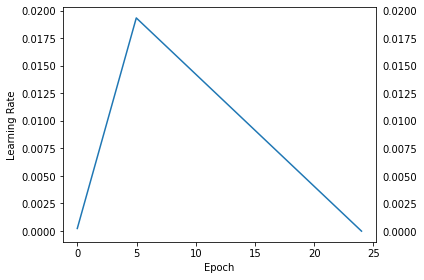

In [72]:
show_lr_history(trainer, EPOCHS)

In [80]:
print(f"Max LR = {max(trainer.lr_history)}")
print(f"Min LR = {min(trainer.lr_history)}")

Max LR = 0.01933891750455231
Min LR = -8.451169266086855e-06


# Get misclassified images from Tester

In [73]:
misclassified_images, predictions, labels = tester.get_misclassified_images()

# Show misclassified images

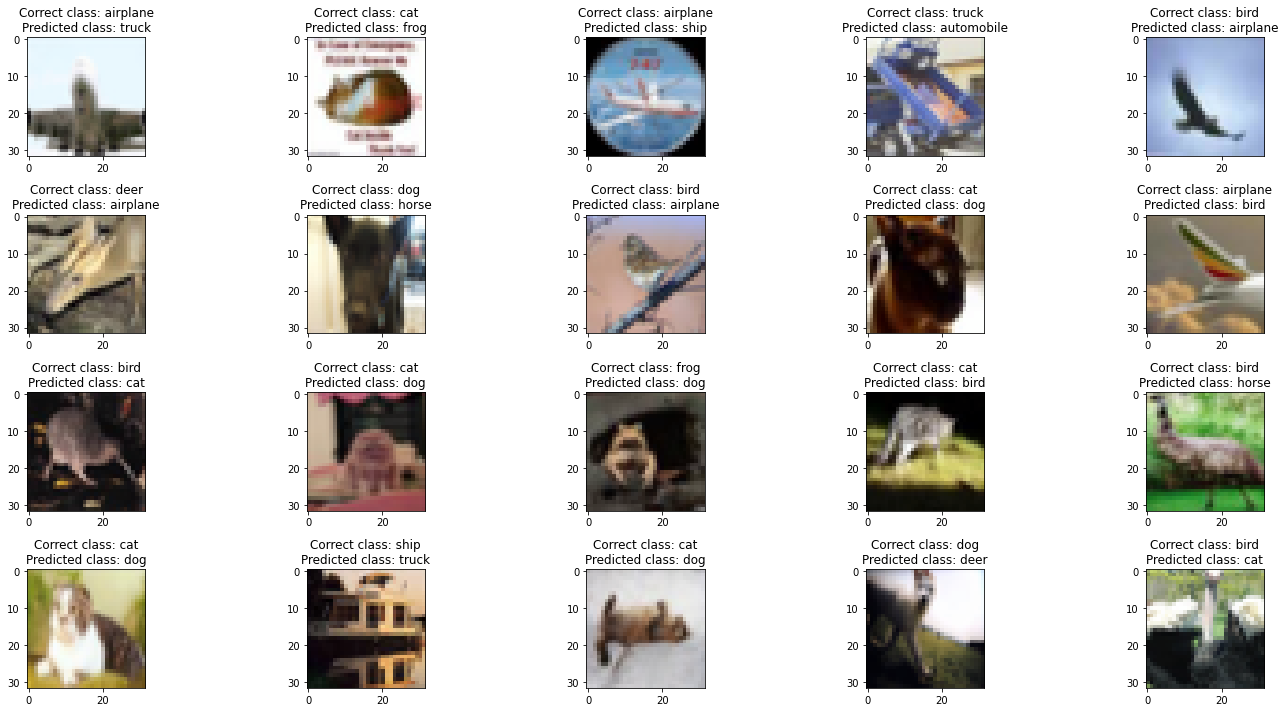

In [74]:
show_misclassified_images(misclassified_images[:20], predictions[:20], labels[:20], cifar10.classes)

# Grad-CAM of misclassified images for correct labels

_This is what model sees for correct labels but it was not enough for correct prediction._

- ## Layer 2

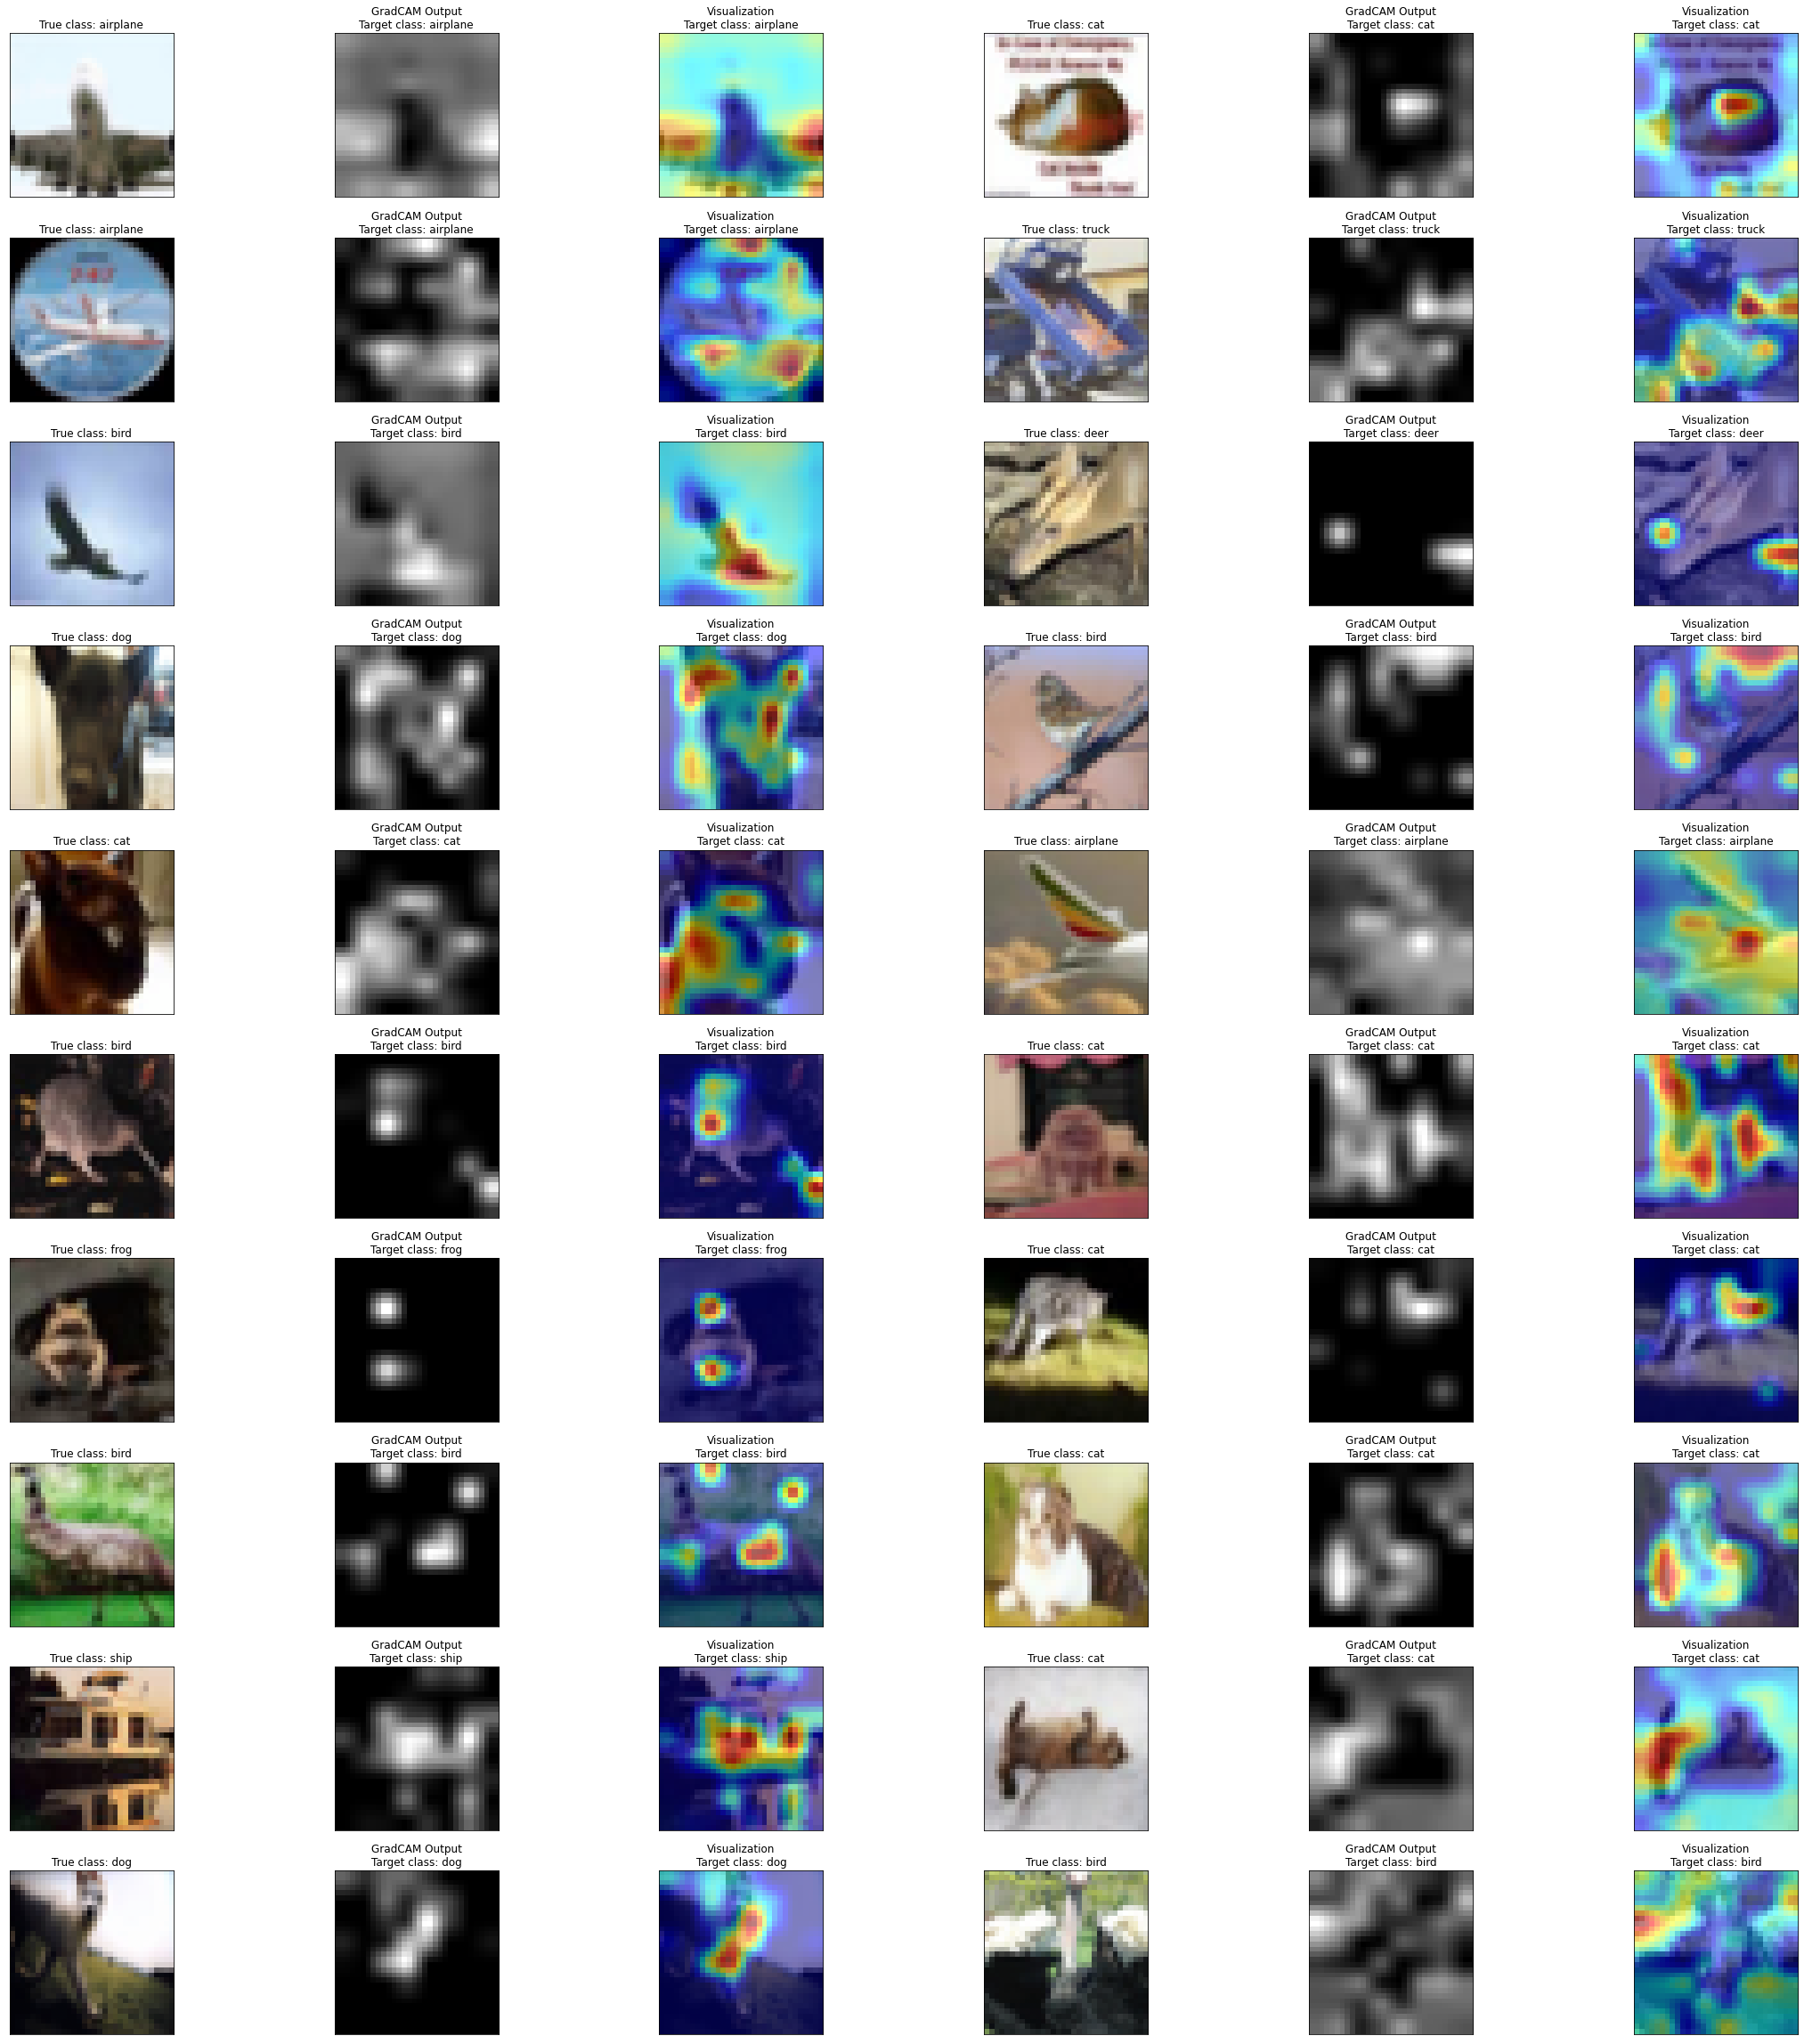

In [75]:
show_grad_cam(model, device, misclassified_images[:20], labels[:20], labels[:20], "layer_2", cifar10.classes)

- ## Layer 3

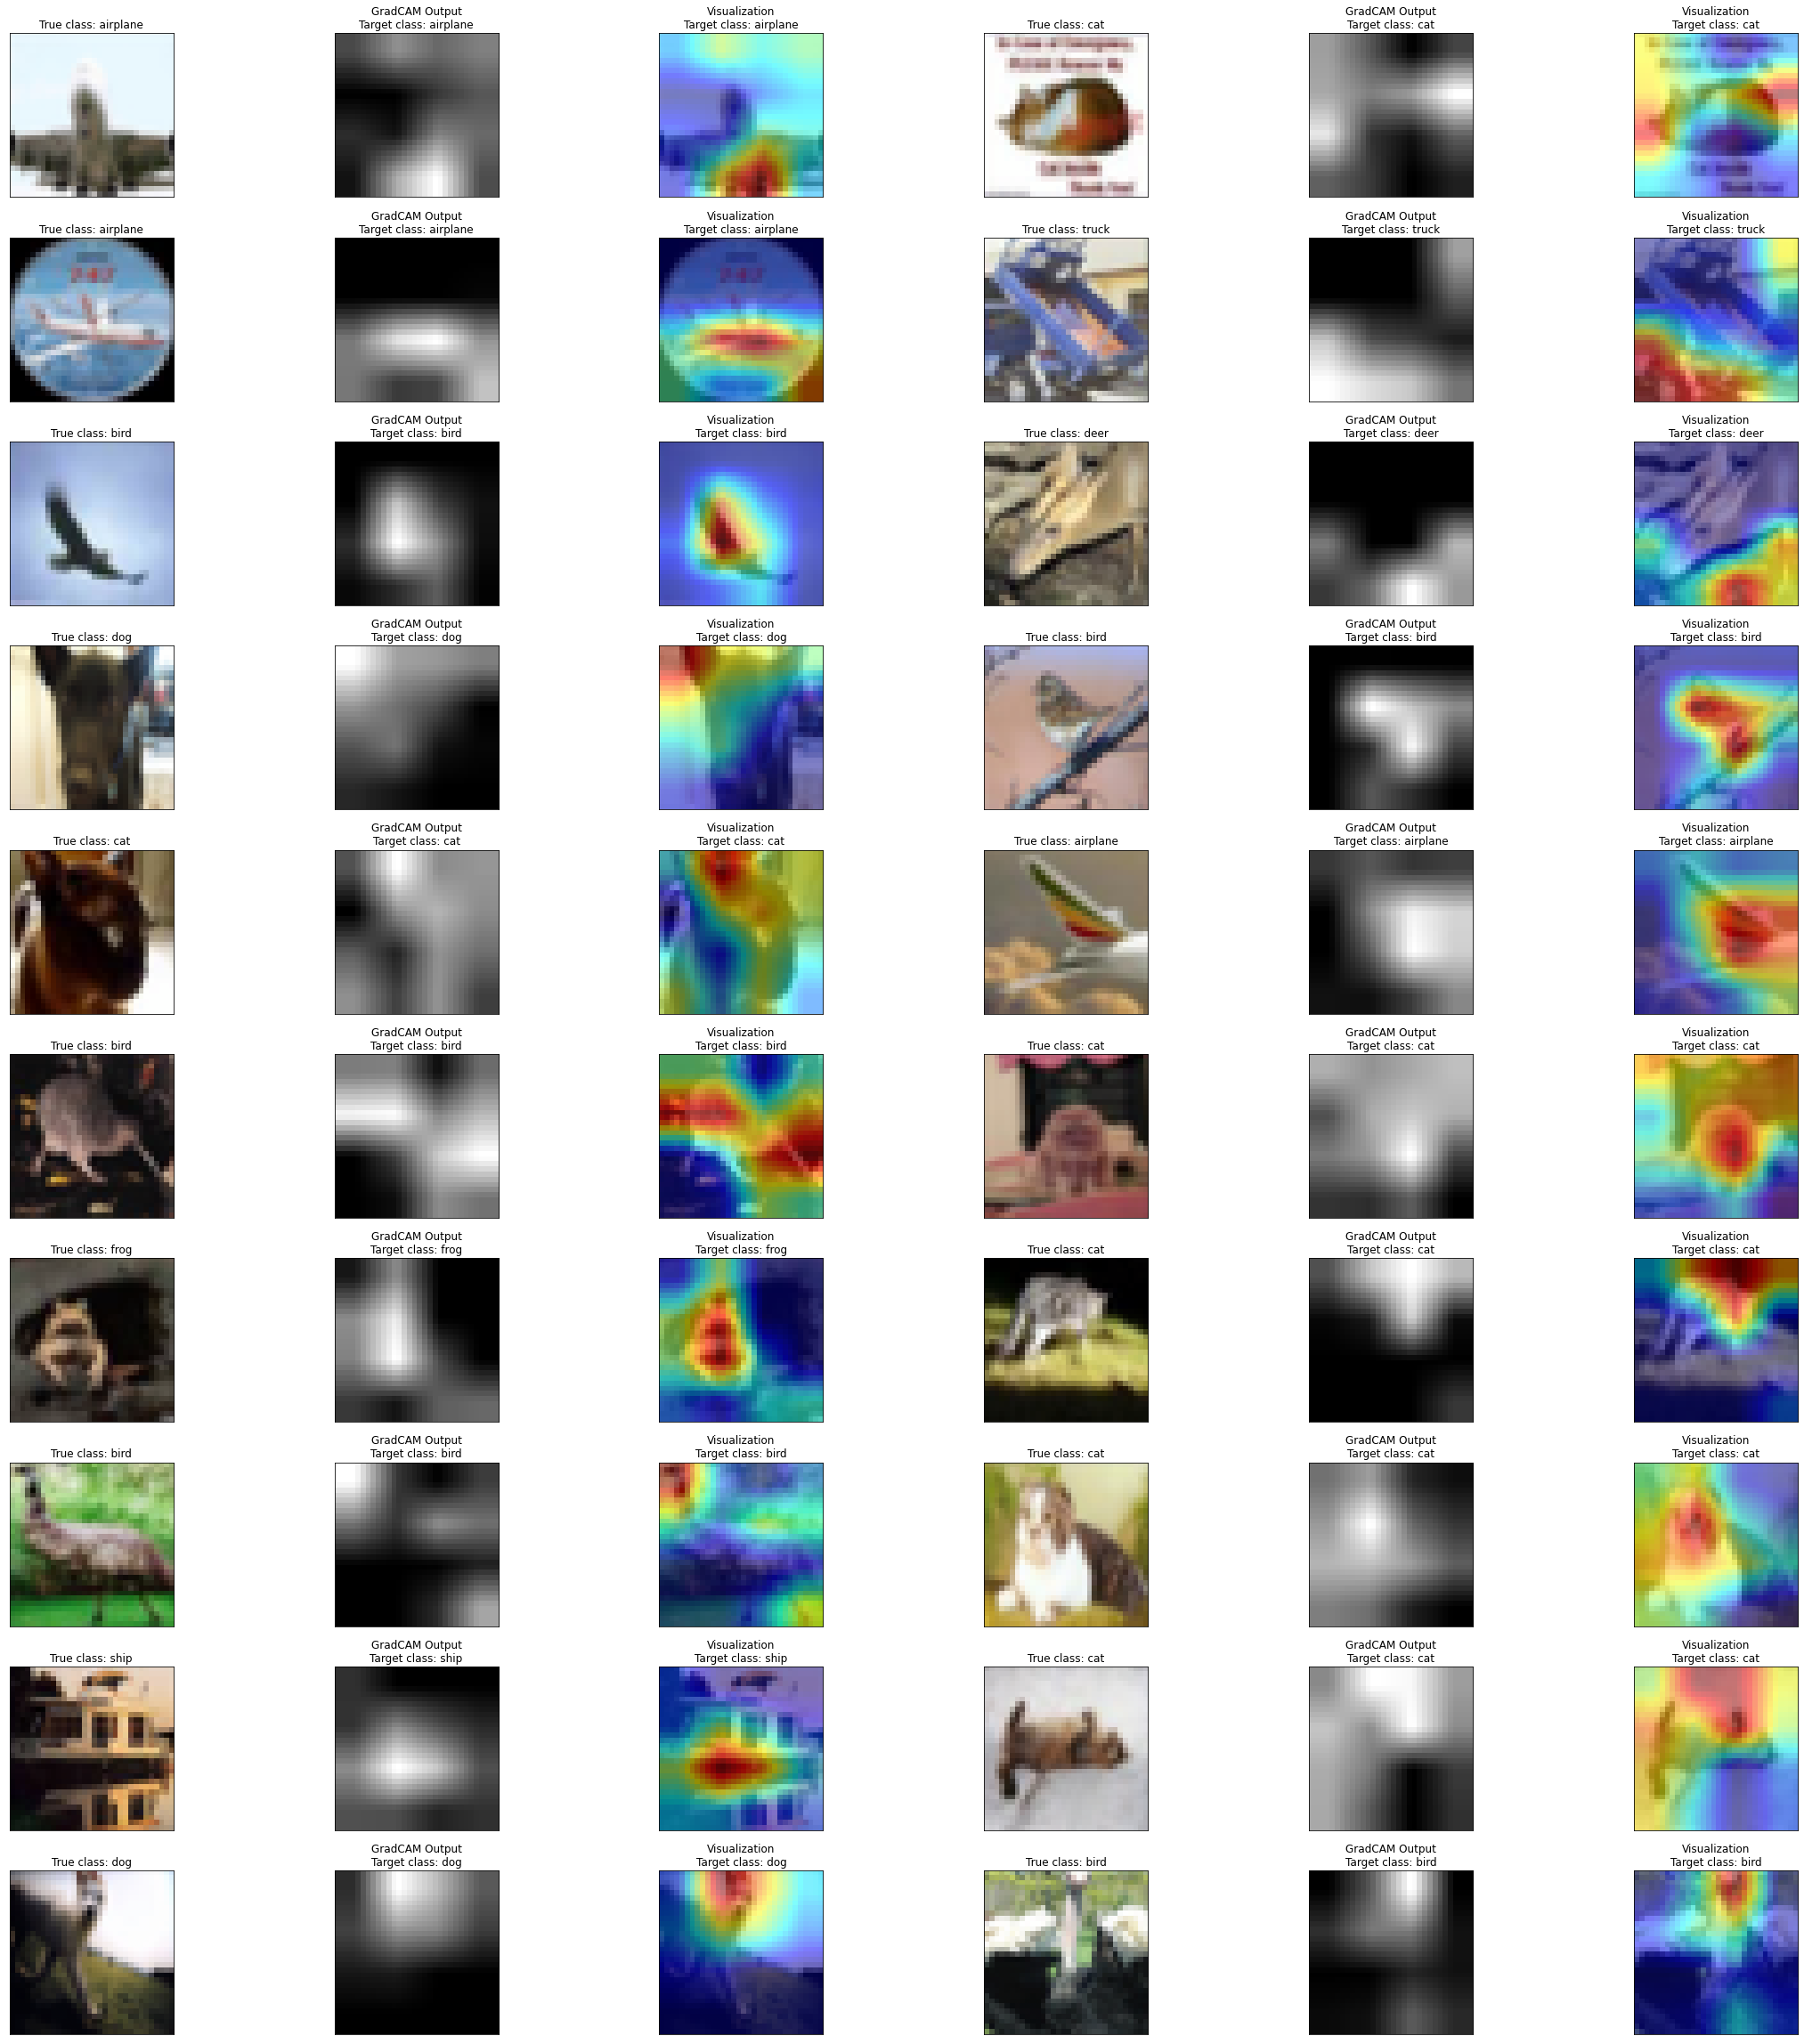

In [76]:
show_grad_cam(model, device, misclassified_images[:20], labels[:20], labels[:20], "layer_3", cifar10.classes)

# Grad-CAM of misclassified images for predictions

_This is what model sees that it based its prediction on._

- ## Layer 2

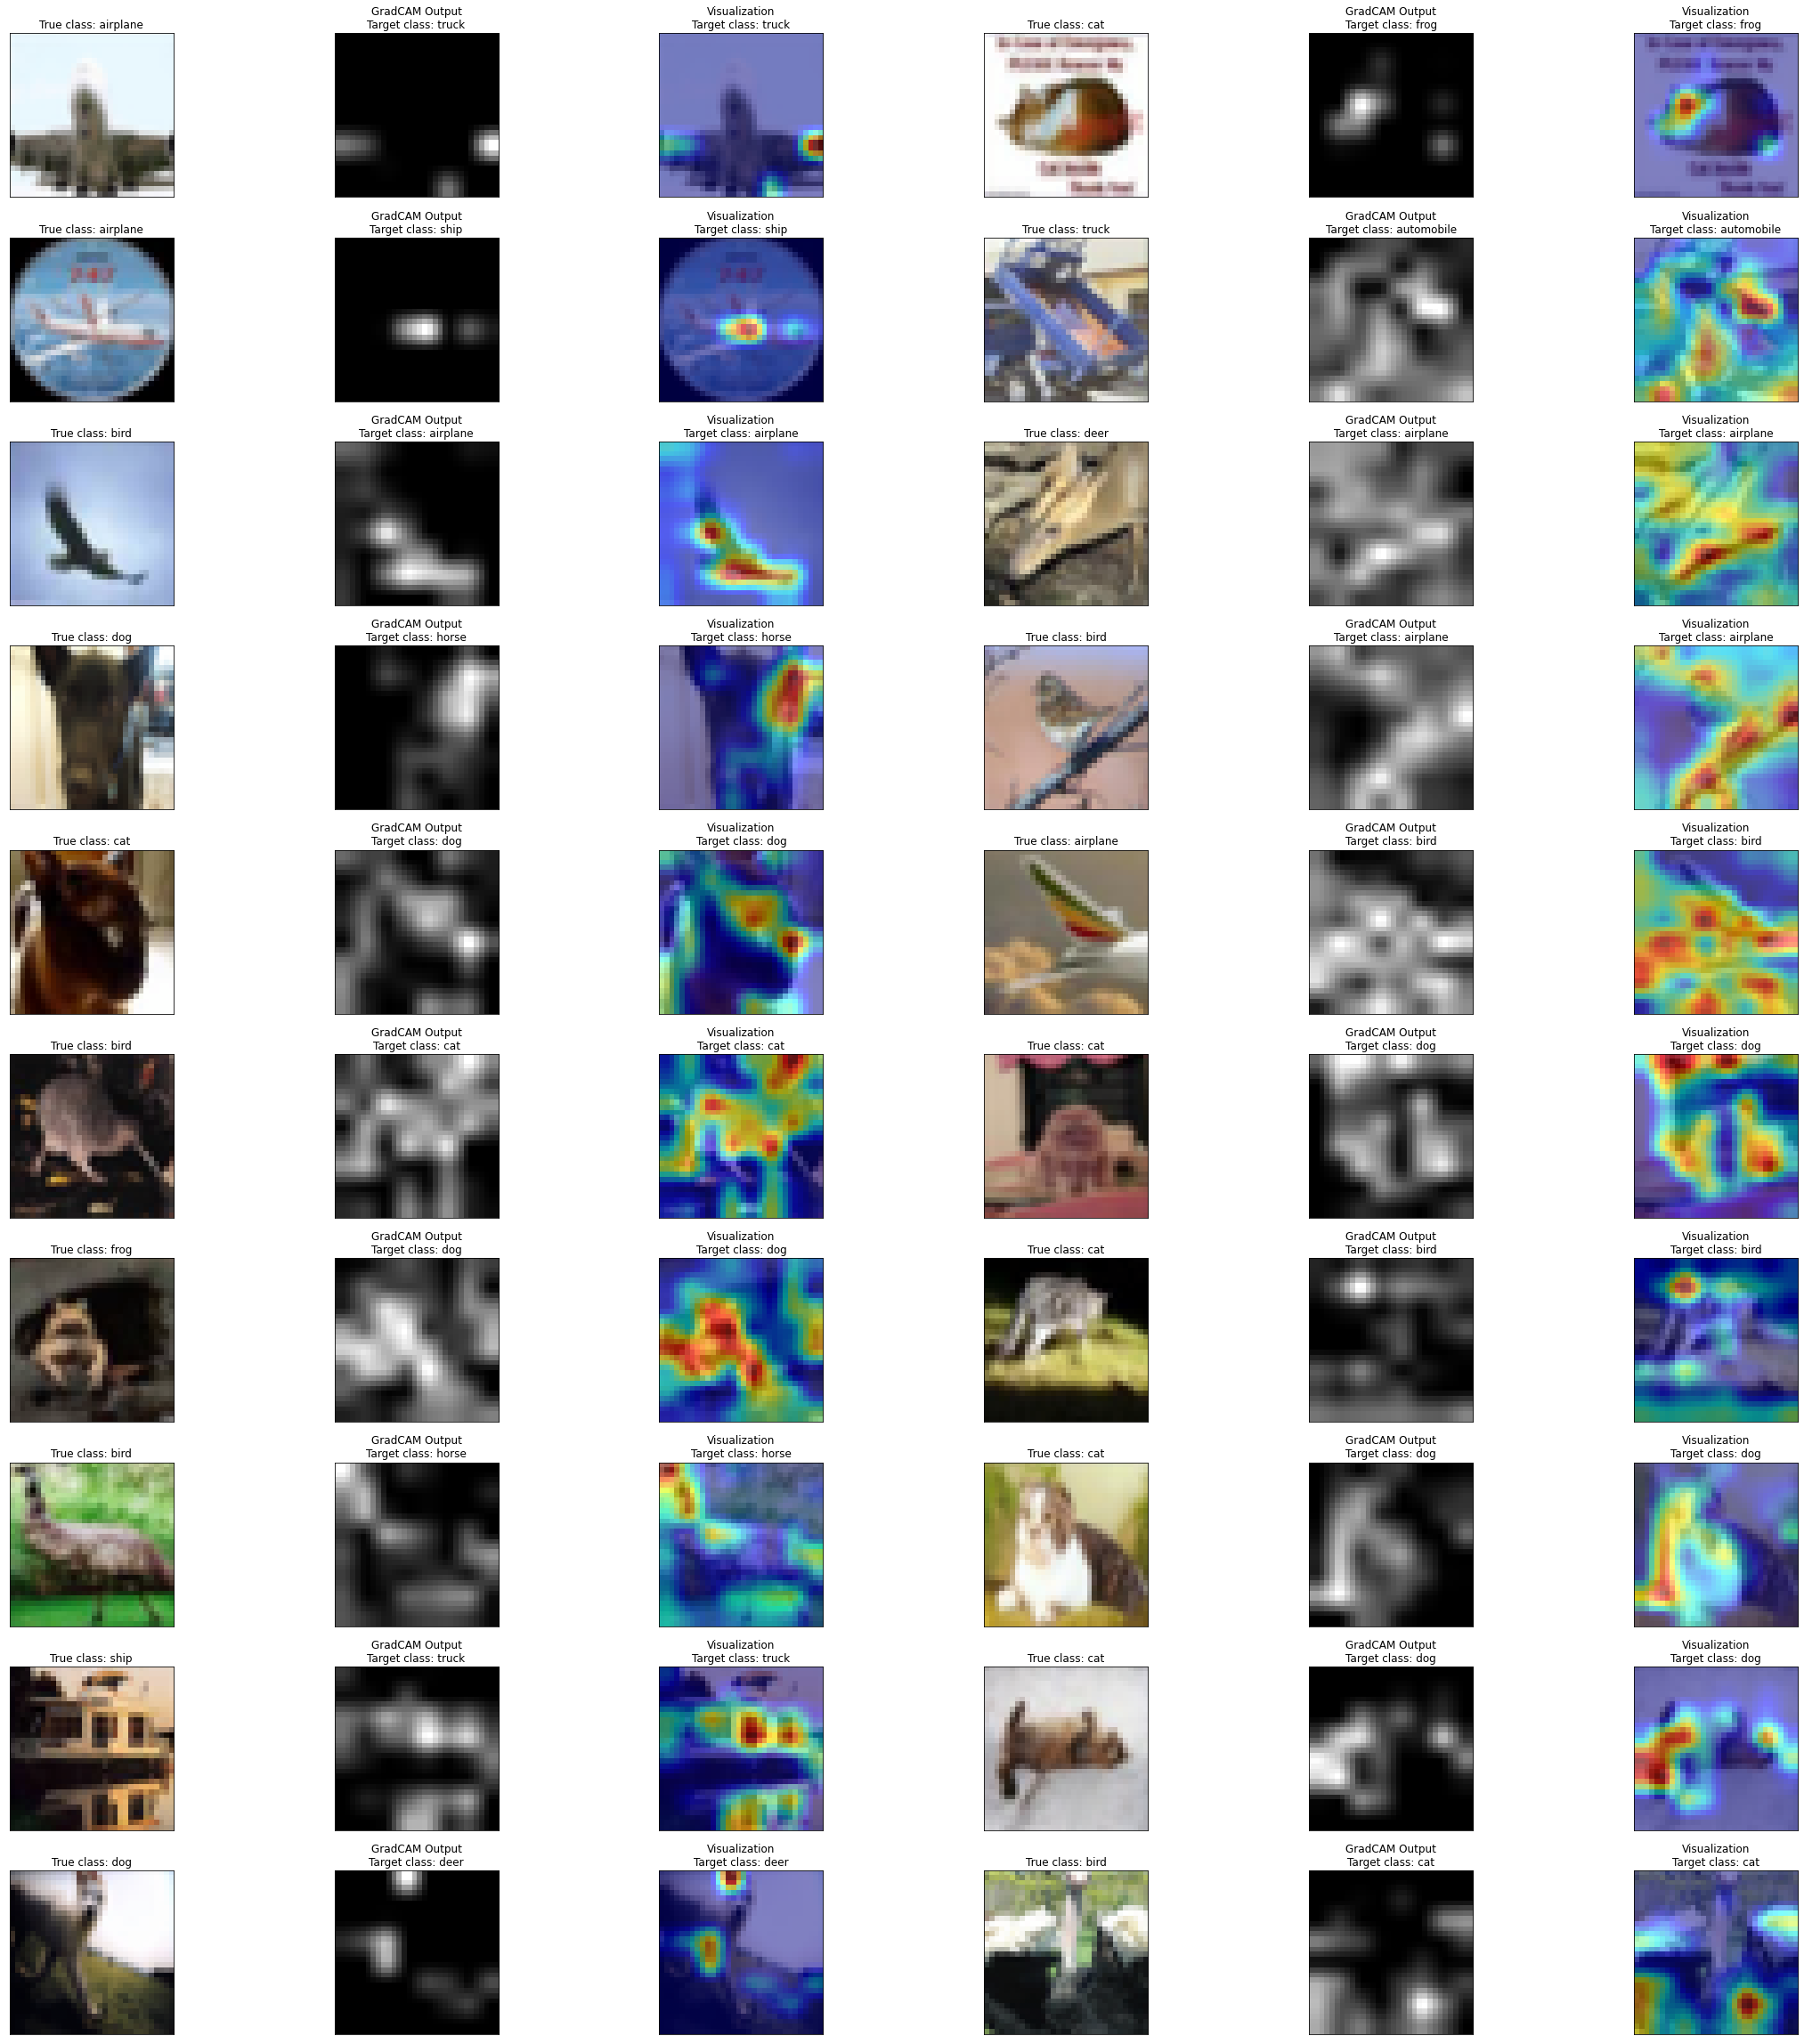

In [77]:
show_grad_cam(model, device, misclassified_images[:20], labels[:20], predictions[:20], "layer_2", cifar10.classes)

- ## Layer 3

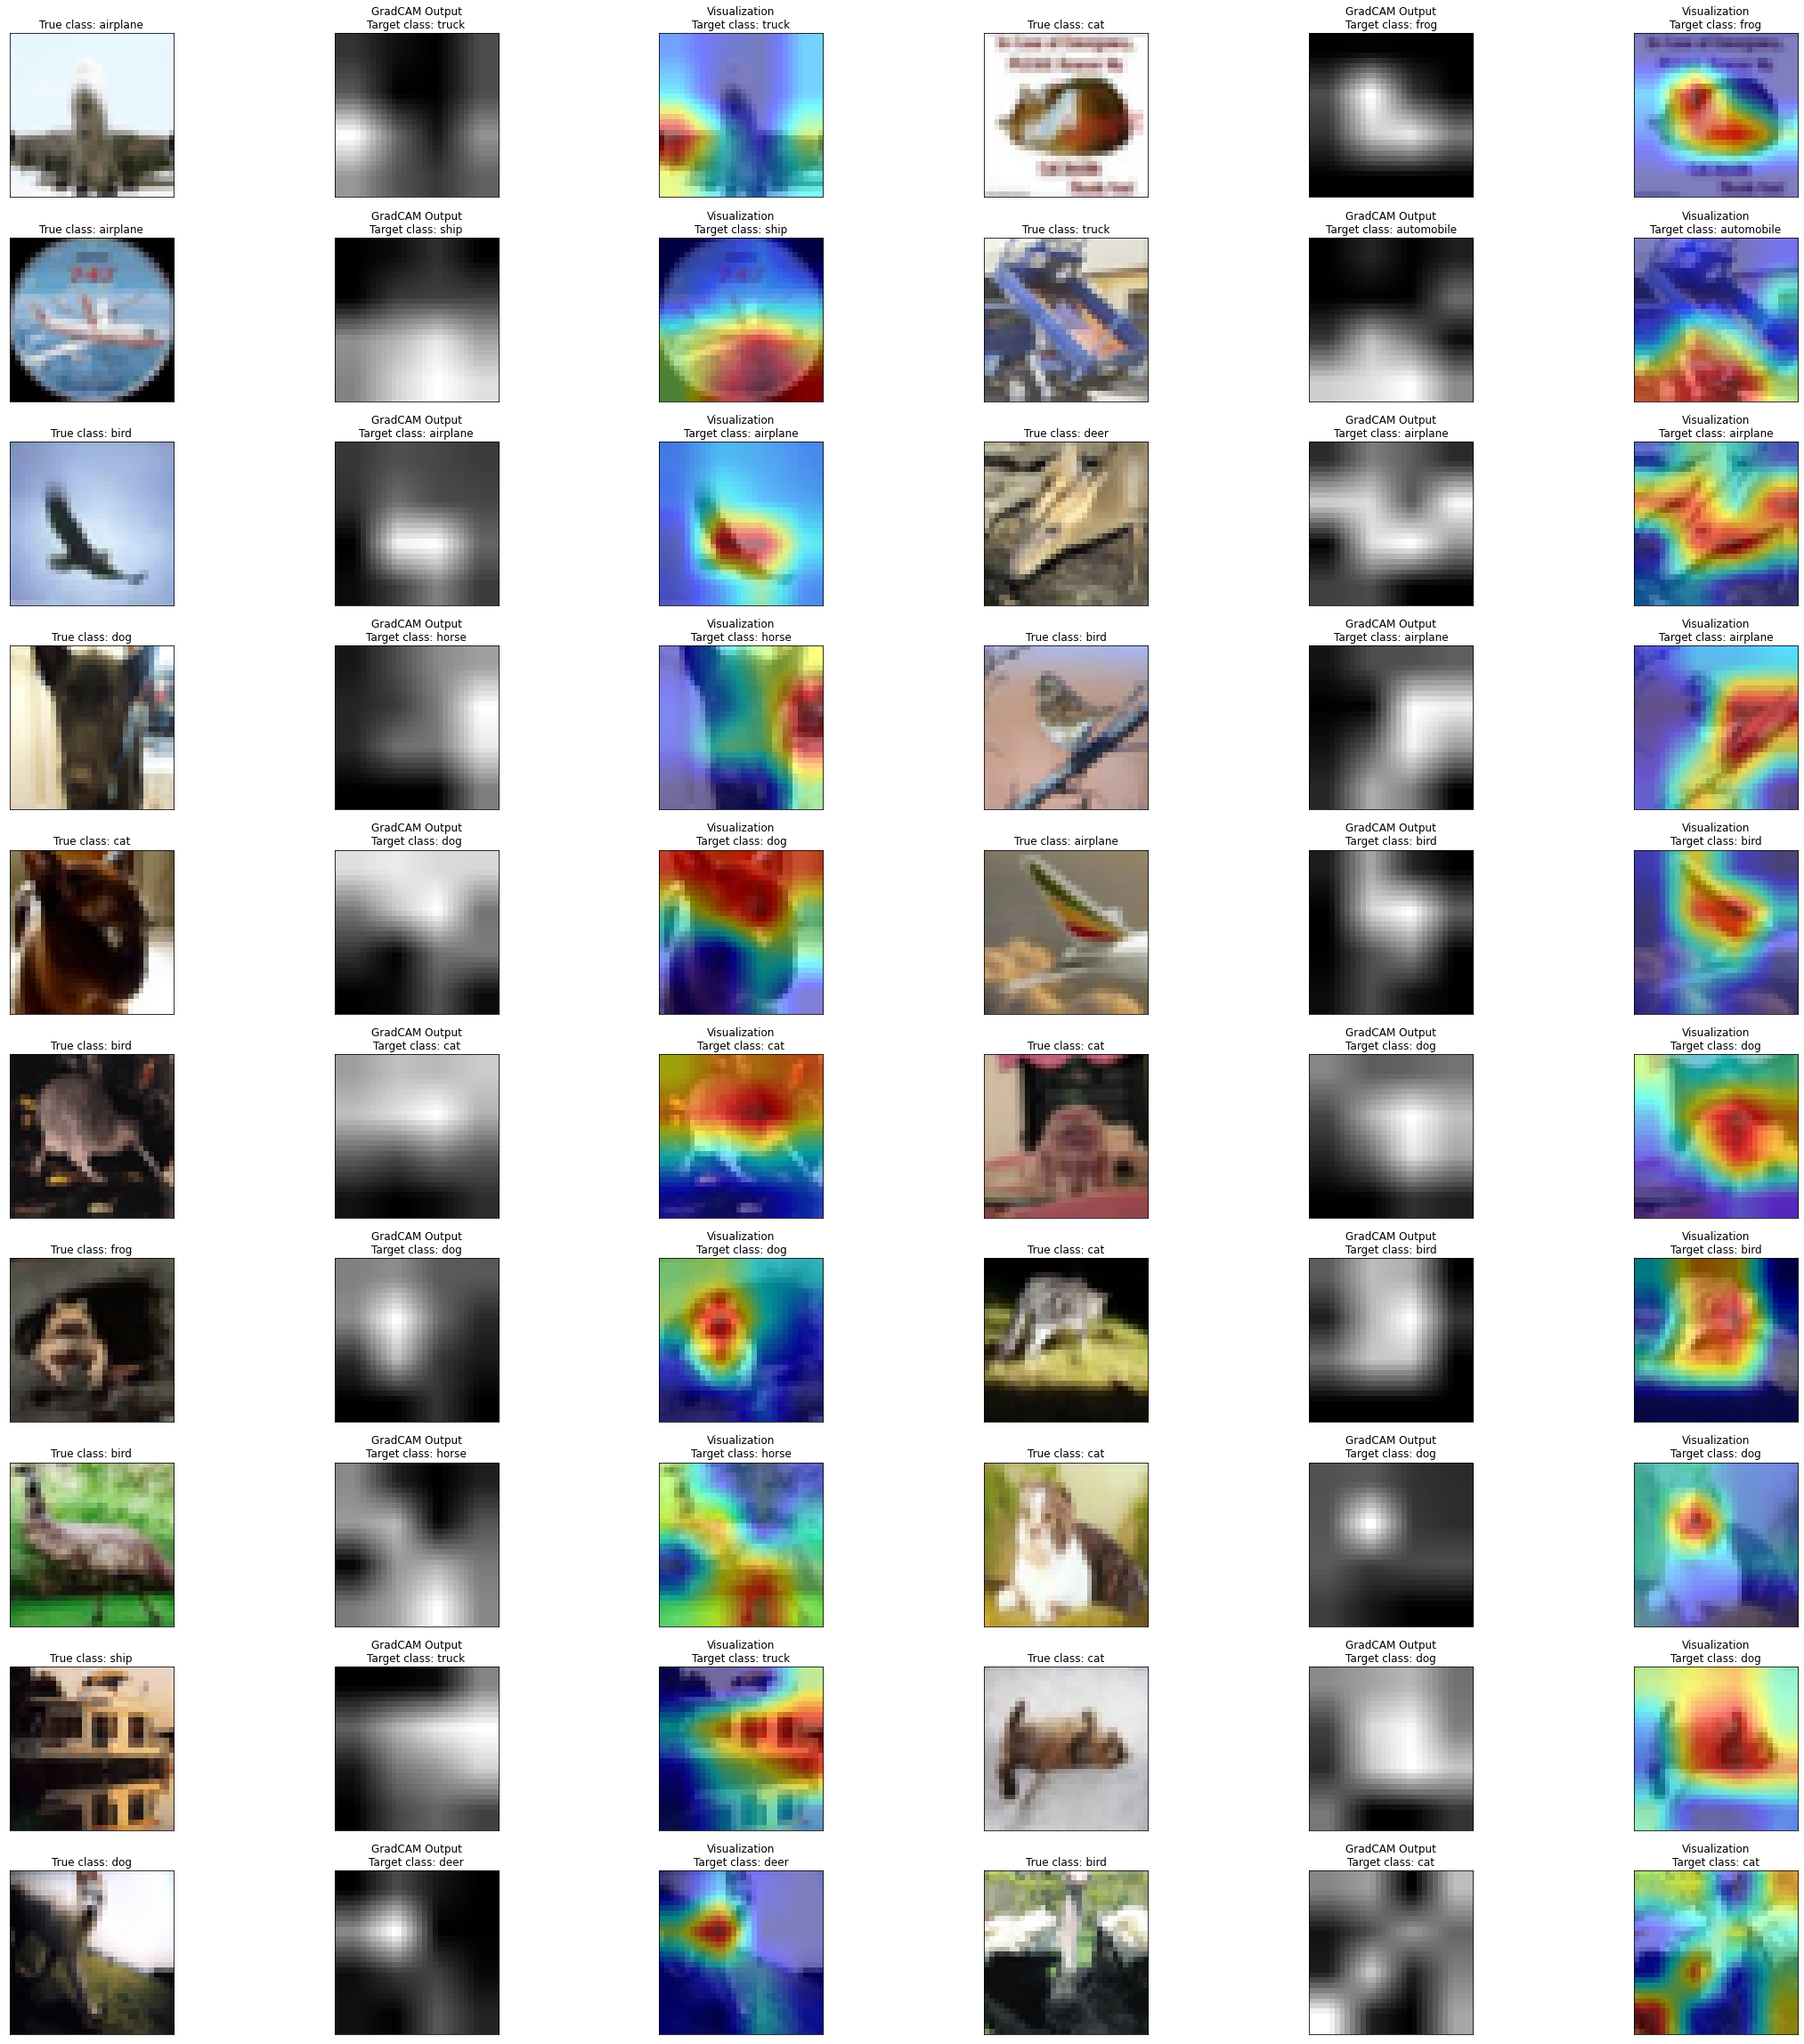

In [78]:
show_grad_cam(model, device, misclassified_images[:20], labels[:20], predictions[:20], "layer_3", cifar10.classes)

# Loss and Accuracy Graphs for Training and Testing

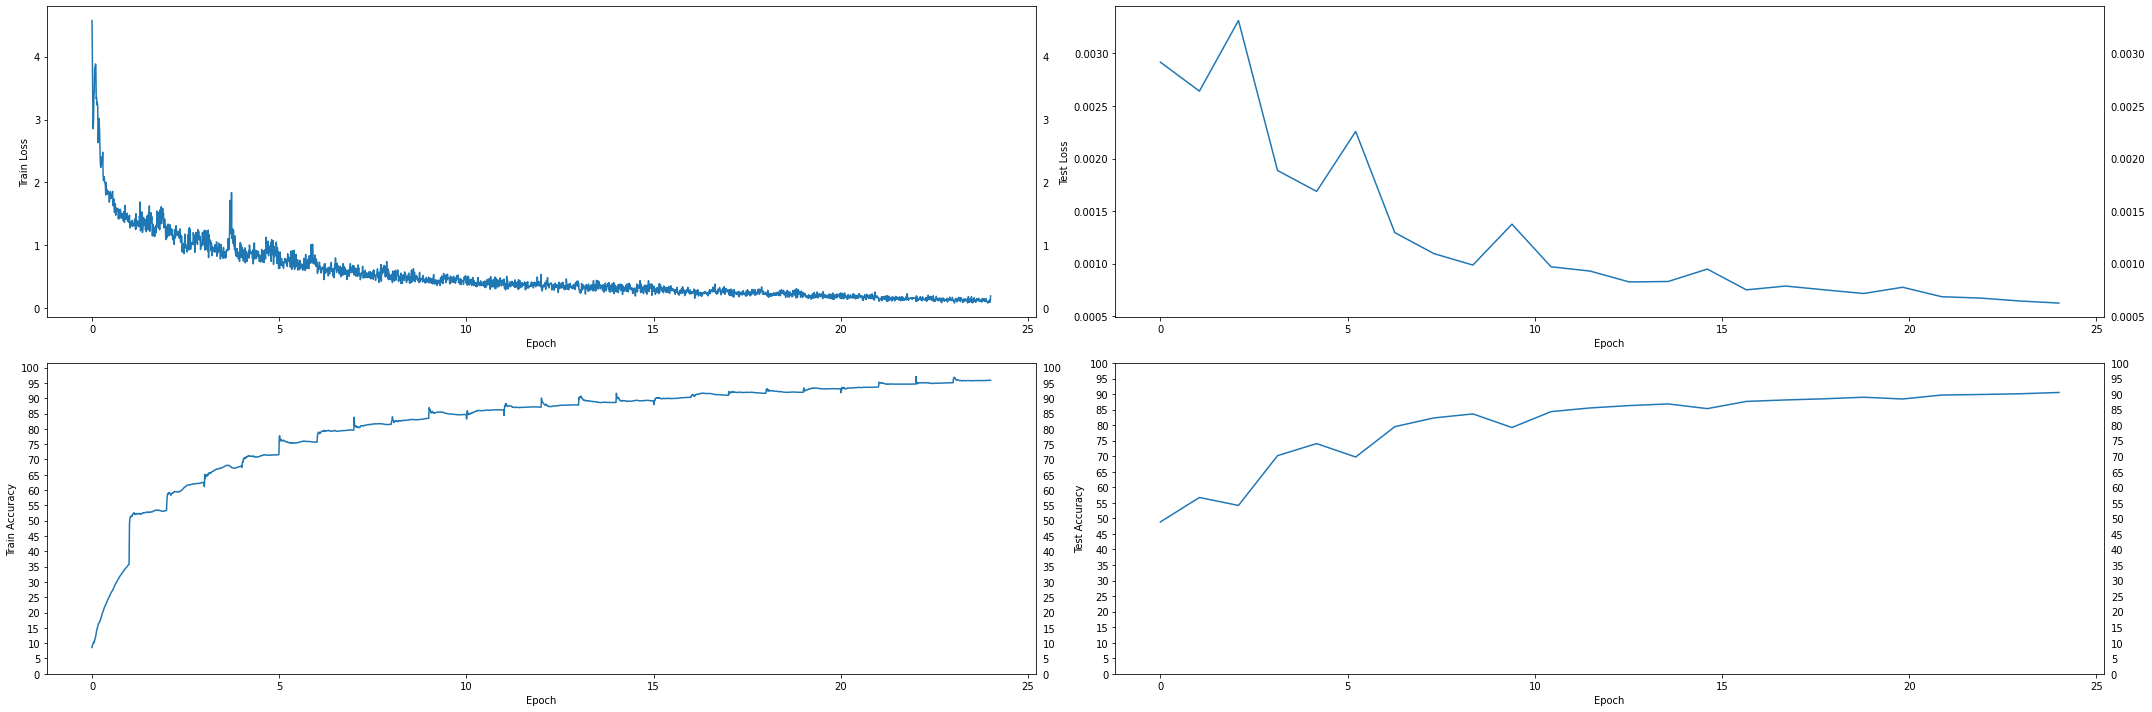

In [79]:
show_losses_and_accuracies(trainer, tester, EPOCHS)